In [41]:
%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# create a tap list

Y = 8
X = 8
N = X * Y
LAMBDA = 2

def to_idx(x, y):
    return y * X + x

tap_list = [
    [(to_idx(1, 1), 1), (to_idx(6, 3), -1)],
    [(to_idx(2, 5), 1), (to_idx(5, 2), -1)]]
dims = len(tap_list)

In [43]:
# generate approximate encoders

approx_encs = NetBuilder.get_approx_encoders(tap_list, Y, X, LAMBDA)

Text(0.5,1,'first two dims')

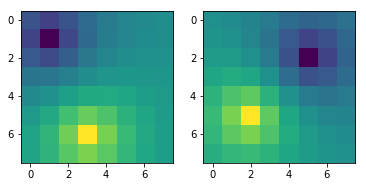

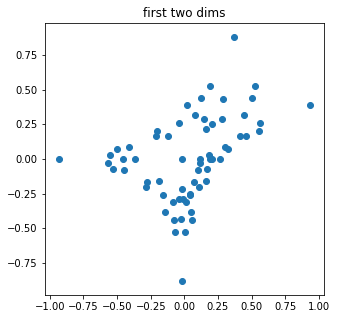

In [44]:
# plot the approximate encoders

yx_approx_encs = approx_encs.T.reshape((dims, Y, X))

fig, ax = plt.subplots(1, 2)
for d in range(dims):
    ax[d].imshow(yx_approx_encs[d, :, :].T)

# first two dims
plt.figure(figsize=(5,5))
plt.scatter(approx_encs[:, 0], approx_encs[:, 1])
plt.title('first two dims')

In [45]:
# get sample points
samples_per_enc = dims + 1
ANGLE_AWAY = np.pi / 6

sample_pts, thresh_encs = NetBuilder.get_sample_points_around_encs(approx_encs, ANGLE_AWAY, samples_per_enc)

Text(0.5,1,'first two dims\ntotal base encs = 9\ntotal sample points = 27')

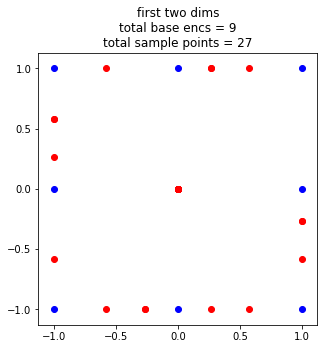

In [46]:
# plot resulting test points

plt.figure(figsize=(5, 5))
plt.scatter(thresh_encs[:, 0], thresh_encs[:, 1], c='b')
plt.scatter(sample_pts[:, 0], sample_pts[:, 1], c='r')
plt.title('first two dims' + 
          '\ntotal base encs = ' + str(thresh_encs.shape[0]) + 
          '\ntotal sample points = ' + str(sample_pts.shape[0]))
          

In [47]:
# now rig up a fake neuron response generator to test this on
# first just do ideal responses, no noise

offset_scale = 20
offsets = (2 * np.random.rand(N,) - 1) * offset_scale
gain_scale = 100
gains = np.random.rand(N,) * gain_scale

def nrn_fn(enc, offset, gain, x):
    return np.maximum(gain * np.dot(enc, x) + offset, 0)

firing_rates = np.zeros((sample_pts.shape[0], N))
for n in range(N):
    for s in range(sample_pts.shape[0]):
        firing_rates[s, n] = nrn_fn(approx_encs[n, :], offsets[n], gains[n], sample_pts[s, :])


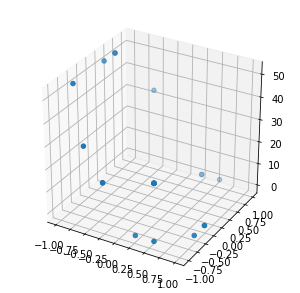

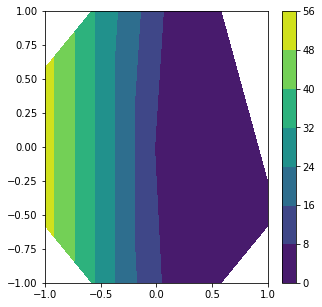

In [48]:
# plot neurons' behaviors

if dims == 2:
    
    # pick a neuron with a reasonable response
    nrn_idx = 0
    while True:
        if (np.abs(offsets[nrn_idx]) < .5 * offset_scale and 
            np.linalg.norm(approx_encs[nrn_idx, :]) > .2):
            break
        nrn_idx += 1
    #nrn_idx = np.random.randint(N)
    
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(sample_pts[:, 0], sample_pts[:, 1], firing_rates[:, nrn_idx])
    
    plt.figure(figsize=(5, 5))
    plt.tricontourf(sample_pts[:, 0], sample_pts[:, 1], firing_rates[:, nrn_idx])
    plt.colorbar()

In [49]:
# try fitting, compare estimates to actual encoders 

baselines = np.maximum(offsets, 0)

est_encs, est_offsets, residuals, insufficient = NetBuilder.estimate_encs_from_tuning_curves(sample_pts, 
                                                                                             firing_rates, 
                                                                                             baselines, 
                                                                                             fired_tolerance=.1)

print(np.sum(insufficient), "/", est_encs.shape[0], "neurons needed more points")

16 / 64 neurons needed more points


In [50]:
print(est_encs[:4, :])
print((approx_encs[:4, :].T * gains[:4]).T)
print(residuals[:4])

[[-4.42206219e+01 -1.06581410e-14]
 [-3.36293765e+00  1.75089781e-01]
 [            nan             nan]
 [-1.61704246e+01  1.28861891e+01]]
[[-44.22062191   0.        ]
 [ -3.36293765   0.17508978]
 [ -5.98907929   1.20596158]
 [-16.17042462  12.8861891 ]]
[-3.10862447e-15  3.84877315e-15             nan  5.45595315e-15]


In [55]:
# now try the same thing with the chip

%load_ext autoreload
%autoreload 2

from pystorm.hal.net_builder import NetBuilder

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(4, 4, 2)


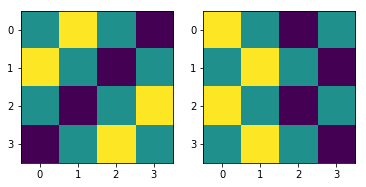

In [64]:
# test the D > 1 create_default_yx_taps function (with no bad taps)
# this is in the SY, SX space, not Y,X space

Y = 8
X = 8
D = 2

SY = Y // 2
SX = X // 2

yx_taps = NetBuilder.create_default_yx_taps(SY, SX, D, bad_syn=np.array([[False] * SY] * SX, dtype=bool))
print(taps.shape)

if D == 1:
    plt.imshow(yx_taps[:, :, 0])
else:
    fig, ax = plt.subplots(1, D, figsize=(D*3,3))
    for d in range(D):
        ax[d].imshow(yx_taps[:, :, d])